# 投影和标签转移

嵌入器本身可以作为分类器，因为他根据 kNN 作出了对于相似性的裁决。使用可嵌入新数据（重训练）的嵌入器可以将一个未知数据集和一个已知的数据集
共同嵌入到同一个低维空间中。根据共同的 kNN 图进行分类和聚类；如果我们能够设法保持原嵌入空间不变（使第一次嵌入的数据点仍然在相同的位置），
我们可以对新数据进行投影。PCA 显然支持这样的可重复性，但其受批次效应影响很大，一些非线性方法如 scVI 也可以支持这样的可重复性，并同时校正
批次效应

尽管 UMAP 本身也支持重训练，但是基于神经网络的 UMAP 效能较传统方法更低，而且难以选择合适的超参数。我们使用 MDE 进行嵌入，他较好的支持
重训练，而且可以创建使得原有数据点可重复的约束

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import exprmat as em
ver = em.version()

[i] exprmat 0.1.46 / exprmat-db 0.1.46
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/bioinfo/packages/exprmat/docs/source/notebooks
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.46)
[i] resident memory: 803.20 MiB
[i] virtual memory: 5.71 GiB


### 准备参考数据集

我们需要对一个参考图谱进行一些必要的准备，这包括:
- 训练一个 scVI / scANVI 嵌入器
- 获得一个合适的图谱级的二维降维表示

在图谱准备工作完毕后，请保存图谱实验对象，这样才会写到硬盘上

In [6]:
atlas = em.load_experiment(
    direc = '/home/data/yangz/bioinfo/geo/m-bone-marrow-metastasis/expm', 
    load_samples = False
)

[!] samples are not dumped in the experiment directory.


In [14]:
print(atlas)

annotated data of size 14626 × 20349
integrated dataset of size 14626 × 20349
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> ppt.pseudotime <f64> ppt.seg <cat> ppt.edge <cat> ppt.milestones <cat>
          cell.type <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool> n.umi <f64>
 layers : counts <f32> magic <f64>
   obsm : harmony <arr:f64(50)> knn.d.nn100 <arr:f32(100)> knn.nn100 <arr:i32(100)>
          pca <arr:f64(50)> ppt <arr:f64(2000)> umap <arr:f32(2)>
   varm :

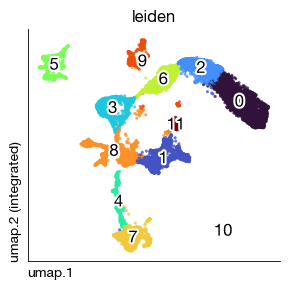

In [9]:
fig = atlas.plot_rna_embedding(
    basis = 'umap', color = 'leiden', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = False
)

In [ ]:
atlas.annotate(
    mapping = {
        'LP': [4], 'B': [7],
        'Stem': [8], 'Mac': [1, 11], 
        'GP': [3], 'Neu': [0, 2, 6],
        'Ery': [9], 'T/NK': [5], 'Mast': [10]
    }
)

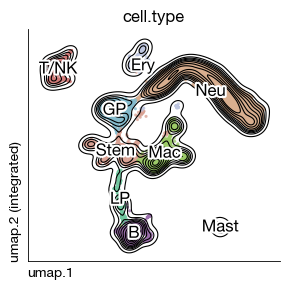

In [13]:
fig = atlas.plot_rna_embedding(
    basis = 'umap', color = 'cell.type', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = True, cmap = 'modlight' 
)

In [ ]:
atlas.run_rna_construct_atlas(
    key_counts = 'counts',
    key_batch = 'batch',
    hvg = 'vst.all.hvg',
    batch_cell_filter = 50,

    # scvi model settings
    scvi_n_epoch = 500,
    scvi_n_latent = 30,
    scvi_n_hidden = 128,
    scvi_n_layers = 2,
    scvi_dropout_rate = 0.1,
    scvi_dispersion = 'gene',
    scvi_gene_likelihood = 'nb',
    scvi_latent_distrib = 'normal',
    scvi_key = 'scvi',

    annotation = 'cell.type',
    scanvi_key = 'scanvi',
    scanvi_unlabel = 'unknown',
    scanvi_max_epochs = 300,
    scanvi_samples_per_label = 250,

    scvi_kwargs = {
        'encode_covariates': True,
        'deeply_inject_covariates': False,
        'use_layer_norm': "both",
        'use_batch_norm': "none",
    },
    scanvi_kwargs = {},
    scanvi_train_kwargs = {
        'early_stopping': True,
        'early_stopping_monitor': 'elbo_validation', 
        'early_stopping_min_delta': 0.001, 
        'early_stopping_patience': 10, 
    },
    scvi_train_kwargs = {
        'early_stopping': True,
        'early_stopping_monitor': 'elbo_validation', 
        'early_stopping_min_delta': 0.0, 
        'early_stopping_patience': 9, 
        'early_stopping_warmup_epochs': 0, 
        'early_stopping_mode': 'min',
        'plan_kwargs': {
            'reduce_lr_on_plateau': True,
            'lr_patience': 8,
            'lr_factor': 0.1,
        }
    }
)

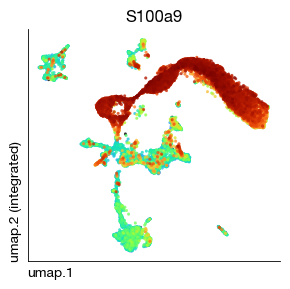

In [86]:
fig = atlas.plot_rna_embedding(
    basis = 'umap', color = 'S100a9', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = False, cmap = 'turbo'
)

In [ ]:
atlas.save(save_samples = False)

### 投影数据集

投影数据集本身不需要太多的准备，便可以对一个已经加载的准备好的参考数据集进行投影。投影数据集的唯一要求是具有原始 UMI 计数矩阵 `counts`

In [16]:
query = em.load_experiment(
    direc = '/home/data/yangz/bioinfo/geo/m-ck-cd45-radiotherapy-crm/expm', 
    load_samples = False, load_subset = 'neutrophil'
)

[!] samples are not dumped in the experiment directory.


In [17]:
print(query)

annotated data of size 4547 × 21687
subset neutrophil of size 4547 × 21687
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> time <cat> kde.time <f64>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <o> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : ambiguous <f64> counts <f32> spliced <f64> unspliced <f64>
   obsm : harmony <arr:f64(50)> knn.d.nn30 <arr:f32(30)> knn.nn30 <arr:i32(30)> pca <arr:f64(50)>
          umap <arr:f32(2)> umap.neu <arr:f32(2)>
   varm : pca <arr:f64(50)>
   obsp : connectivities.nn30 <csr:f3

`re_embed` 参数可以选择是否要训练一个全新的共同嵌入。如果为 `False`，嵌入器将被约束为使得原有的图谱保持在同一位置，使新的嵌入
直观可视。然而，如果样本密度偏差很大，新的嵌入点可能极端的聚集在很近的位置，而无法展示更细节的结构

In [ ]:
query.run_rna_project(
    atlas = atlas,
    atlas_modality = 'rna',         # must match
    atlas_embedding = 'umap',
    counts_key = 'counts',
    batch_key = 'batch',
    key_query_latent = 'scanvi',
    scanvi_unlabel = 'unknown',     # must match
    scvi_epoch_reduction = 3,
    predict_labels = 'cell.type',
    key_added = 'projection',

    # mde settings
    re_embed = True,                # whether to re-embed the data:
                                    # set re-embed to False will preserve the atlas embedding as is, and fit the 
                                    # query dataset directly onto it.
    max_iter = 500,
    verbose = True,
)

In [48]:
print(query)

annotated data of size 4547 × 21687
subset neutrophil of size 4547 × 21687
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> time <cat> kde.time <f64> cell.type <o>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <o> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : ambiguous <f64> counts <f32> spliced <f64> unspliced <f64>
   obsm : harmony <arr:f64(50)> knn.d.nn30 <arr:f32(30)> knn.nn30 <arr:i32(30)> pca <arr:f64(50)>
          umap <arr:f32(2)> umap.neu <arr:f32(2)> scanvi <arr:f32(30)> projection <arr:f32(2)>
   var

In [50]:
query['rna'].uns['projection']

,batch,annotation,x,y,xf,yf
normal:1,b1,Neu,12.729420,9.945438,12.729420,9.945438
normal:2,b1,Neu,11.946812,9.857353,11.946812,9.857353
normal:3,b1,Neu,13.211775,9.681957,13.211775,9.681957
normal:4,b1,Neu,14.602674,6.856853,14.602674,6.856853
normal:5,b1,Neu,10.504195,11.880738,10.504195,11.880738
...,...,...,...,...,...,...
niche:3955,b3,Mast,12.856742,-5.243686,12.856742,-5.243686
niche:3956,b3,Mac,5.710707,1.318341,5.710707,1.318341
niche:3957,b3,Neu,15.598707,6.654189,15.598707,6.654189
niche:3958,b3,Mac,4.438360,2.887758,4.438360,2.887758


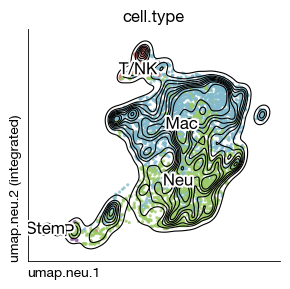

In [51]:
query['rna'].obs['cell.type'] = query['rna'].obs['cell.type'].astype('category')
fig = query.plot_rna_embedding(
    basis = 'umap.neu', color = 'cell.type', annotate_style = 'text', legend = False,
    figsize = (3, 3), dpi = 100, ptsize = 4, contour_plot = True, cmap = 'modlight'
)

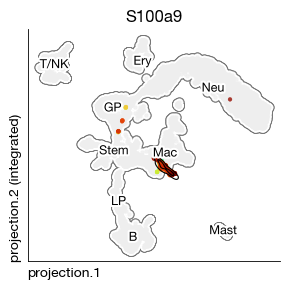

In [73]:
# re-embed = False
fig = query.plot_rna_projection(
    color = 'S100a9', cmap = 'turbo',
    figsize = (3, 3), dpi = 100, projection_key = 'projection',
    contour_plot = True, 
    contour_fill = False,
    contour_levels = 3,
    contour_bw = 2,

    # atlas background
    background = 'annotation',
    annotate = True, annotate_fontsize = 9, 
)

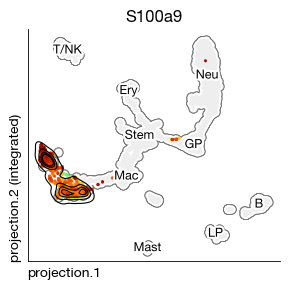

In [111]:
# re-embed = True
fig = query.plot_rna_projection(
    color = 'S100a9', cmap = 'turbo',
    figsize = (3, 3), dpi = 100, projection_key = 'projection',
    contour_plot = True, 
    contour_fill = False,
    contour_levels = 5,
    contour_bw = 1,
    ptsize = 4, alpha = 1,

    # atlas background
    background = 'annotation',
    annotate = True, annotate_fontsize = 9, 
)

In [ ]:
query.save(save_samples = False)